# Part 3A: Data Modeling with Music Features

This part of the project will focus on building different classification modles using the audio feature data only. Audio feature was previously collected using the Spotify API wrapper, Spotipy, in Step 1A. These features include variables such as speechiness, acousticness, tempo, and mode. 

The target variable is the music **genre** for each song. Since the target includes 4 potential outputs - country, rock, dance pop, and hip hop, this project is a **mutli-classification** or **multinomial classification** problem.

In [153]:
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

#sci-kit learn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# keras
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K

from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, roc_curve, auc)

from imblearn.over_sampling import RandomOverSampler


Import data (audio features from Spotify).

In [43]:
df = pd.read_csv('../data/data_audio.csv')

In [44]:
df.head(3)

,id,track,artist_id,artist,album_id,album,release_date,link,danceability,energy,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,6qc34bnVOyqGDPni8H5W0U,Amazed,3qbnxnvUqR14MJ9g8QwZJK,Lonestar,7ykiOoPC4GLrVYSDVdDGq2,Lonely Grill,1999,https://api.spotify.com/v1/tracks/6qc34bnVOyqG...,0.561,0.543,...,0.124,0.243,139.803,audio_features,spotify:track:6qc34bnVOyqGDPni8H5W0U,https://api.spotify.com/v1/tracks/6qc34bnVOyqG...,https://api.spotify.com/v1/audio-analysis/6qc3...,240867,4,country
1,3EUl8M6SzxZl03NPkB8mUd,Neon Moon,0XKOBt59crntr7HQXXO8Yz,Brooks & Dunn,1ZXM9jY3Bsg12KXgwftBrO,#1s ... and then some,2009-09-08,https://api.spotify.com/v1/tracks/3EUl8M6SzxZl...,0.698,0.632,...,0.118,0.458,102.408,audio_features,spotify:track:3EUl8M6SzxZl03NPkB8mUd,https://api.spotify.com/v1/tracks/3EUl8M6SzxZl...,https://api.spotify.com/v1/audio-analysis/3EUl...,263760,4,country
2,7lUE02KHkZM44BZgjCaWRO,Meet In the Middle,0svyIX7Xu3DVMkrOtB88i6,Diamond Rio,5zpRuHrOSBkOrop2DJvBcr,Diamond Rio,1991-07-01,https://api.spotify.com/v1/tracks/7lUE02KHkZM4...,0.746,0.443,...,0.223,0.554,91.110,audio_features,spotify:track:7lUE02KHkZM44BZgjCaWRO,https://api.spotify.com/v1/tracks/7lUE02KHkZM4...,https://api.spotify.com/v1/audio-analysis/7lUE...,198333,4,country


In [45]:
df.genre.value_counts(normalize=True)

rock         0.299270
dance_pop    0.286715
hip_hop      0.245839
country      0.168175
Name: genre, dtype: float64

What is the baseline accuracy?

In [47]:
df['genre'].value_counts(normalize=True)

rock         0.299270
dance_pop    0.286715
hip_hop      0.245839
country      0.168175
Name: genre, dtype: float64

In [161]:
def get_metrics(model_name, model, X, y, over=False):
    #create labels and empty df
    labels = ['country','dance_pop','hip_hop','rock']
    #set up model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    #if oversampling is False, fit on regular X_train, y_train splot
    if over==False:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        train_score = model.score(X_train,y_train)
    #if oversampling is True, use RandomOverSample to balance classes for training data
    elif over==True:
        oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_over, y_over = oversample.fit_resample(X_train, y_train)
        model.fit(X_over,y_over)
        preds = model.predict(X_test)
        train_score = model.score(X_over, y_over)
    #store results
    data = confusion_matrix(y_test, preds)
    results = {labels[i] : data[i][i]/sum(data[i]) for i in range(0, len(data))}
    result_df = pd.DataFrame(results, index=[0])
    result_df['model'] = model_name
    result_df['oversampling'] = over
    result_df['train_accuracy'] = train_score
    result_df['accuracy'] = model.score(X_test,y_test)
    return result_df[['model','oversampling','train_accuracy','accuracy'] + labels]

In [48]:
features = ['valence','liveness','acousticness','tempo','instrumentalness','energy','danceability','duration_ms',
           'speechiness','loudness','mode']

## KNN Multi-Classification

For KNN, what combination of features (for X data) will yield the best scores for a KNN classifier?

In [53]:
#best_features = knn_feature_scores.head(1)['combo'].item()
X = df[features]
y= df['genre']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

In [55]:
knn_neighbor_scores = []
for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    result = {'neighbors': i, 'train': knn.score(X_train,y_train), 'test': knn.score(X_test,y_test)}
    knn_neighbor_scores.append(result)

knn_neighbor_scores_df = pd.DataFrame(knn_neighbor_scores)

<AxesSubplot:xlabel='neighbors', ylabel='test'>

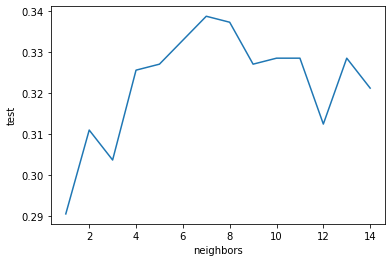

In [56]:
sns.lineplot(data=knn_neighbor_scores_df, x="neighbors", y="test")

In [83]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
knn.score(X_train,y_train), knn.score(X_test,y_test)

(0.5047445255474453, 0.34890510948905107)

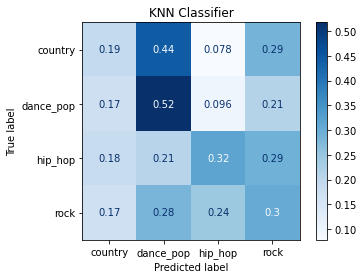

In [115]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap="Blues", normalize='true')
plt.title("KNN Classifier");

## Decision Tree Classifier
Create a decision tree classifier model.

In [59]:
X = df[features]
y = df['genre']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

Test out max depth with a loop. Which max depth parameter gives us the best accuracy score?

In [86]:
dtc_depth_scores = []
for i in range(1,21):
    dtc = DecisionTreeClassifier(max_depth=i)
    dtc.fit(X_train,y_train)
    result = {'max_depth': i, 'train': dtc.score(X_train,y_train), 'test': dtc.score(X_test,y_test)}
    dtc_depth_scores.append(result)

In [87]:
pd.DataFrame(dtc_depth_scores).sort_values('test',ascending=False).head(3)

,max_depth,train,test
5,6,0.722263,0.671533
6,7,0.761679,0.662774
7,8,0.807299,0.658394


In [88]:
dtc = DecisionTreeClassifier(max_depth = 6)
dtc = dtc.fit(X_train, y_train)

dtc.score(X_train, y_train), dtc.score(X_test,y_test)

(0.7222627737226277, 0.67007299270073)

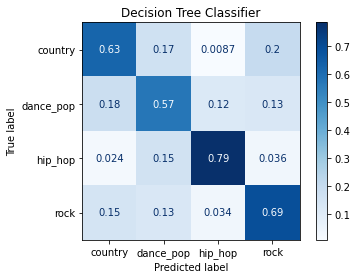

In [89]:
ConfusionMatrixDisplay.from_estimator(dtc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Decision Tree Classifier");

## Random Forest Classifier

In [168]:
X = df[features]
y = df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 42)

In [95]:
X2 = df_cat[features+keys]
y2 = df_cat['genre']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, stratify=y, random_state = 42)

In [169]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
rfc.score(X_train,y_train), rfc.score(X_test,y_test)

(1.0, 0.7226277372262774)

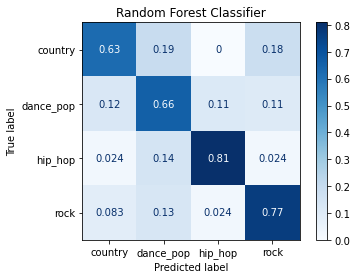

In [170]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Random Forest Classifier");
plt.savefig('../plots/Audio_RFC.jpeg')

In [96]:
rfc2 = RandomForestClassifier(random_state=42)
rfc2.fit(X_train2,y_train2)
rfc2.score(X_train2,y_train2), rfc2.score(X_test2,y_test2)

(1.0, 0.7328467153284671)

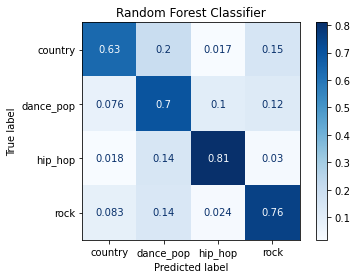

In [98]:
ConfusionMatrixDisplay.from_estimator(rfc2, X_test2, y_test2, cmap="Blues", normalize='true')
plt.title("Random Forest Classifier");

## Random Forest with GridSearch

In [71]:
rfc_gs = GridSearchCV(rfc, param_grid={'n_estimators': [100,200,250], 
                                       'max_depth': [None,1,2,3],
                                       'bootstrap': [True,False]
                                       })
rfc_gs.fit(X_train, y_train)
print(rfc_gs.best_score_)
rfc_gs.best_params_

0.724087591240876


{'bootstrap': True, 'max_depth': None, 'n_estimators': 100}

In [72]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train,y_train)
rfc.score(X_train,y_train), rfc.score(X_test,y_test)

(1.0, 0.6992700729927007)

# Classifier Models with Oversampling
The dataset is not perfectly balanced, e.g. there are not as many country songs as there are rock or dance pop songs. To adjust, we will use an oversampling technique with **RandomOverSampler** to supplement training data and balance the target classes (genres).

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

In [74]:
y_train.value_counts()

rock         820
dance_pop    785
hip_hop      674
country      461
Name: genre, dtype: int64

In [75]:
from imblearn.over_sampling import RandomOverSampler

Create new X_train and y_train with over sampling method. Set strategy to auto to produce perfectly balanced classees based on majority amount.

In [76]:
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
y_over.value_counts()

rock         820
country      820
hip_hop      820
dance_pop    820
Name: genre, dtype: int64

## KNN with OverSampling

In [77]:
knn = KNeighborsClassifier()
knn.fit(X_over,y_over)
knn.score(X_over,y_over), knn.score(X_test,y_test)

(0.5777439024390244, 0.3284671532846715)

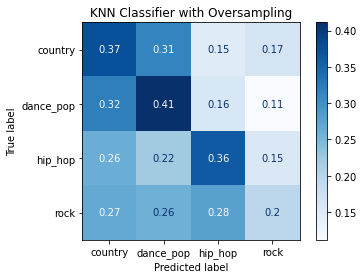

In [78]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap="Blues", normalize='true')
plt.title("KNN Classifier with Oversampling");

## Decision Tree Classifier with Oversampling

In [79]:
dtc = DecisionTreeClassifier(max_depth = 7)
dtc.fit(X_over, y_over)
dtc.score(X_over, y_over), dtc.score(X_test,y_test)

(0.7646341463414634, 0.6437956204379562)

## Random Forest with Oversampling

In [80]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_over,y_over)
rfc.score(X_over,y_over), rfc.score(X_test,y_test)

(1.0, 0.7313868613138687)

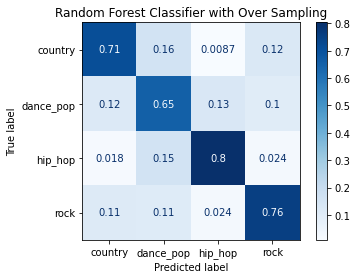

In [166]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, cmap="Blues", normalize='true')
plt.title("Random Forest Classifier with Over Sampling");
plt.savefig('../plots/Audio_RFC_OS.jpeg')

# Results Summarized

In [164]:
results = pd.concat([get_metrics('KNN', knn, X, y),
           get_metrics('KNN', knn, X, y, True),
           get_metrics('Decision Tree Classifier', dtc, X, y),
           get_metrics('Decision Tree Classifier', dtc, X, y, True),
           get_metrics('Random Forest Classifier', rfc, X, y),
           get_metrics('Random Forest Classifier', rfc, X, y, True),
          ])


results

,model,oversampling,train_accuracy,accuracy,country,dance_pop,hip_hop,rock
0,KNN,False,0.504745,0.348905,0.191304,0.517766,0.315476,0.302439
0,KNN,True,0.540549,0.313869,0.347826,0.365482,0.339286,0.224390
0,Decision Tree Classifier,False,0.722263,0.668613,0.626087,0.573604,0.779762,0.692683
0,Decision Tree Classifier,True,0.730793,0.648175,0.730435,0.527919,0.738095,0.643902
0,Random Forest Classifier,False,1.000000,0.722628,0.626087,0.659898,0.809524,0.765854
0,Random Forest Classifier,True,1.000000,0.731387,0.713043,0.654822,0.803571,0.756098


In [165]:
results.to_csv('../data/model_results_audio.csv', index=False)